In [1]:
from pdf_reader import PDFReader
from preprocessor import Preprocessor
from vectorizer import Vectorizer
from visualizer import DocumentVisualizer
from models.svm_model import SVMModel
from models.rf_model import RFModel
from models.lr_model import LRModel
from sklearn.ensemble import VotingClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import os
import numpy as np

In [2]:
# Load Word2Vec model
vectorizer = Vectorizer("word2Vec_models/cbow_s50.txt")

In [3]:
pdf_reader = PDFReader()
preprocessor = Preprocessor()
document_visualizer = DocumentVisualizer()

# Create BoW representation of documents
count_vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
lda = LatentDirichletAllocation(n_components=2, random_state=42)

# Define individual models
svm_clf = SVMModel()
rf_clf = RFModel()
log_clf = LRModel()

# Create a voting classifier
voting_clf = VotingClassifier(
    estimators=[('svm', svm_clf), ('rf', rf_clf), ('log', log_clf)],
    voting='soft'
)

In [4]:
# Process labeled data

X_texts = []
X_word2vec = []
y = []

# Loop through each PDF in the documents folder
for filename in os.listdir('documents/'):
    if filename.endswith('.pdf'):
        # Read and preprocess the text
        text = pdf_reader.extract_text(os.path.join('documents', filename))
        processed_text = preprocessor.process(text)
        X_texts.append(' '.join(processed_text))
        vectorized_text = vectorizer.calculate_document_vector(processed_text)
        X_word2vec.append(vectorized_text)

        # Assign labels based on file naming convention
        if filename.startswith("risk"):
            label = 0  # Risk Report
        elif filename.startswith("privacy"):
            label = 1  # Privacy Policy
        else:
            label = -1  # Unlabeled or other types of documents
        y.append(label)

# Transform documents to a matrix of token counts
X_count = count_vectorizer.fit_transform(X_texts)

# Apply LDA
X_topics = lda.fit_transform(X_count)

# Combining Word2Vec and LDA representations
X_combined = np.hstack((X_word2vec, X_topics))

# Transform y to numpy array
y = np.array(y)

# Train ensemble model on the combined representation
voting_clf.fit(X_combined, y)

VotingClassifier(estimators=[('svm', SVMModel()), ('rf', RFModel()),
                             ('log', LRModel())],
                 voting='soft')

In [5]:
# Analyze new data

new_X_texts = []
new_X_word2vec = []
doc_names = []

for filename in os.listdir('analyze/'):
  if filename.endswith('.pdf'):
    new_text = pdf_reader.extract_text(os.path.join('analyze', filename))
    new_processed_text = preprocessor.process(new_text)
    new_X_texts.append(' '.join(new_processed_text))
    new_vectorized_text = vectorizer.calculate_document_vector(new_processed_text)
    new_X_word2vec.append(new_vectorized_text)
    doc_names.append(filename)  # Store the filename for later reference

# Transform new documents to a matrix of token counts
new_X_count = count_vectorizer.transform(new_X_texts)

# Apply LDA on new data
new_X_topics = lda.transform(new_X_count)

# Combining Word2Vec and LDA representations for new data
new_X_combined = np.hstack((new_X_word2vec, new_X_topics))

# Predicting labels for new data
predictions = voting_clf.predict(new_X_combined)

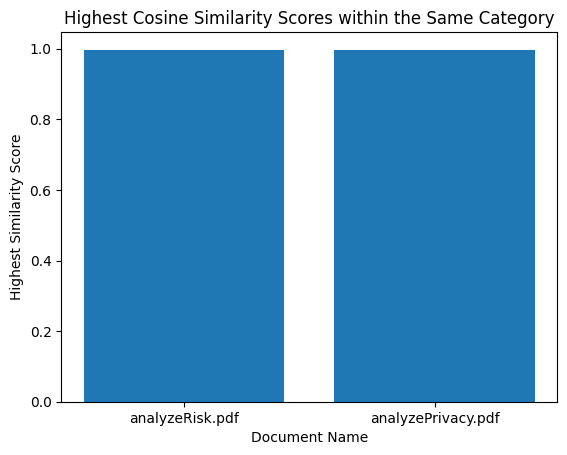

The highest similarity score of analyzeRisk.pdf within its category is: 99.73.
The highest similarity score of analyzePrivacy.pdf within its category is: 99.72.
analyzeRisk.pdf: Risk Report
analyzePrivacy.pdf: Privacy Policy

Done!


In [6]:
# Plot the analyzed data

# Calculate and plot the highest similarity scores
highest_scores = document_visualizer.calculate_similarity(new_X_combined, X_combined, y, predictions)
document_visualizer.plot_similarity(highest_scores, doc_names)

# Print out the highest similarity scores for each document
document_visualizer.print_highest_scores(highest_scores, doc_names)

# Print out predictions with document names
label_names = ["Risk Report", "Privacy Policy"]

for doc_name, label_index in zip(doc_names, predictions):
    print(f"{doc_name}: {label_names[label_index]}")

print("\nDone!")